In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

/home/thasin/Plant_disease_detection-master/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.70G/2.70G [08:01<00:00, 6.02MB/s] 

Extracting files...


Path to dataset files: /home/thasin/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from keras.applications import VGG16,VGG19
from glob import glob
from keras.utils import to_categorical
from keras.layers import  Dense,Conv2D,BatchNormalization,GlobalAveragePooling2D,MaxPooling2D,Flatten,Dropout
from keras.models import Model
from keras.optimizers import SGD,Adam
from keras.initializers import he_normal
from keras.regularizers import l1, l2
plt.style.use("ggplot")

In [3]:
tf.__version__

'2.16.1'

In [2]:
def train_test_df(path,is_test=False):

    img_path = list()
    img_label = list()

    
    if is_test:
       
        for img_file_path in pathlib.Path(path).glob("*.JPG"):
            img_path.append(str(img_file_path))  # Store the image path
            
            # Assuming label is derived from the filename, for example, before the first underscore
            img_label.append(str(img_file_path.stem).split("_")[0])
            
    else:        
       
       for single_class_dir_path in pathlib.Path(path).glob("*"):
           
           if single_class_dir_path.is_dir():
               
               label = single_class_dir_path.stem
               
               for img_file_path in pathlib.Path(single_class_dir_path).glob("*.[jJ][pP][gG]"):
       
                    img_path.append(str(img_file_path))  # Store the image path
                    # Assuming label is derived from the filename, for example, before the first underscore
                    img_label.append(label)

    return pd.DataFrame(data={"img_path":img_path,"label":img_label})    

In [3]:

train_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
test_path = "/kaggle/input/new-plant-diseases-dataset/test/test"

In [4]:
train_df = train_test_df(train_path,is_test=False)
valid_df = train_test_df(valid_path,is_test=False)
test_df = train_test_df(test_path,is_test=True)

In [7]:
train_df.head()

,img_path,label
0,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
1,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
2,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
3,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight
4,/kaggle/input/new-plant-diseases-dataset/New P...,Tomato___Late_blight


In [42]:
test_df.head()

,img_path,label
0,/kaggle/input/new-plant-diseases-dataset/test/...,TomatoEarlyBlight6
1,/kaggle/input/new-plant-diseases-dataset/test/...,TomatoYellowCurlVirus4
2,/kaggle/input/new-plant-diseases-dataset/test/...,TomatoYellowCurlVirus6
3,/kaggle/input/new-plant-diseases-dataset/test/...,PotatoHealthy2
4,/kaggle/input/new-plant-diseases-dataset/test/...,TomatoYellowCurlVirus5


In [20]:
training_set = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 70295 files belonging to 38 classes.


In [21]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 17572 files belonging to 38 classes.


In [22]:
# Define augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),   # Randomly flip images
    tf.keras.layers.RandomRotation(0.2),       # Rotate images slightly
    tf.keras.layers.RandomZoom(0.1),           # Apply zoom effect
])

training_set = training_set.map(lambda x, y: (data_augmentation(x, training=True), y))


In [23]:
training_set

<_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 38), dtype=tf.float32, name=None))>

In [24]:
def plant_disease_cnn():

    vgg16 = VGG16(include_top=False,input_shape=(128,128,3),weights="imagenet",pooling=None)
    vgg16.trainable = True
    
    for layer in vgg16.layers[:-4]:
        layer.trainable = False # Freeze all but the last 4 layers
        
    input_to_vgg16 = vgg16.input
    vgg16_output = vgg16.output
    
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer=he_normal(), kernel_regularizer=l2(0.01))(vgg16_output)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = GlobalAveragePooling2D()(x)  # formula = output_c = 1 / (H * W) * sum_{i=1}^{H} sum_{j=1}^{W} X[i, j, c]
    
    x = Dense(128,activation='relu', kernel_initializer=he_normal(), kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64,activation='relu', kernel_initializer=he_normal(), kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    
    vgg16_output = Dense(38,activation='softmax', kernel_initializer=he_normal(), kernel_regularizer=l2(0.01))(x)
    
    model = Model(inputs=[input_to_vgg16], outputs=[vgg16_output])

    return model

In [25]:
model = plant_disease_cnn()
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 2, 64)       │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,32

 Total params: 15,028,966 (57.33 MB)

 Trainable params: 7,393,574 (28.20 MB)

 Non-trainable params: 7,635,392 (29.13 MB)

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [28]:
# Train the model
batch_size = 64
history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=10,  # Adjust the number of epochs based on your dataset
    steps_per_epoch=len(train_df) // batch_size,
    validation_steps=len(valid_df) // batch_size
)

Epoch 1/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 286s 260ms/step - accuracy: 0.3307 - loss: 4.8782 - val_accuracy: 0.8725 - val_loss: 1.1223
Epoch 2/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6522 - loss: 1.8210 - val_accuracy: 0.8056 - val_loss: 1.3223
Epoch 3/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 285s 259ms/step - accuracy: 0.8393 - loss: 1.2227 - val_accuracy: 0.8402 - val_loss: 1.0668
Epoch 4/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 38us/step - accuracy: 0.8696 - loss: 1.0101 - val_accuracy: 0.8889 - val_loss: 0.9530
Epoch 5/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 280s 255ms/step - accuracy: 0.9079 - loss: 0.9083 - val_accuracy: 0.9494 - val_loss: 0.6433
Epoch 6/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 37us/step - accuracy: 0.9565 - loss: 0.6538 - val_accuracy: 0.9722 - val_loss: 0.6195
Epoch 7/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 284s 259ms/step - accuracy: 0.9324 - loss: 0.7512 - val_accuracy: 0.9181 - val_loss: 0.7229
Epoch 8/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 37us/step - accuracy: 0.95

In [29]:
#Training set Accuracy
train_loss, train_acc = model.evaluate(training_set)
print('Training accuracy:', train_acc)

1099/1099 ━━━━━━━━━━━━━━━━━━━━ 276s 251ms/step - accuracy: 0.9670 - loss: 0.5121
Training accuracy: 0.9670957922935486


In [35]:
train_loss, train_acc

(0.5105248689651489, 0.9670957922935486)

In [30]:
#Validation set Accuracy
val_loss, val_acc = model.evaluate(validation_set)
print('Validation accuracy:', val_acc)

275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9401 - loss: 0.6001
Validation accuracy: 0.9424653053283691


In [34]:
val_loss, val_acc

(0.5904715061187744, 0.9424653053283691)

In [31]:
model.save('models.h5') #save entire weights and architeture

In [32]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


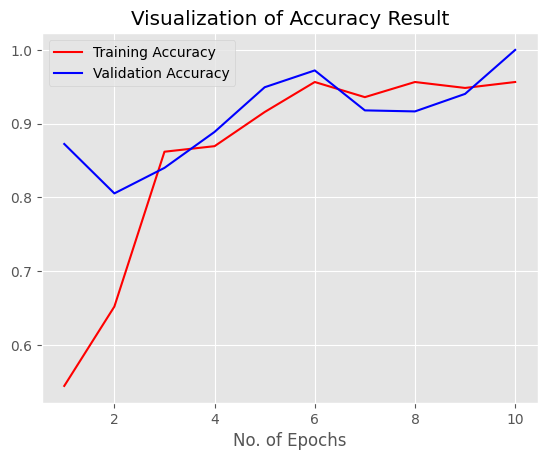

In [36]:
epochs = [i for i in range(1,11)]
plt.plot(epochs,history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

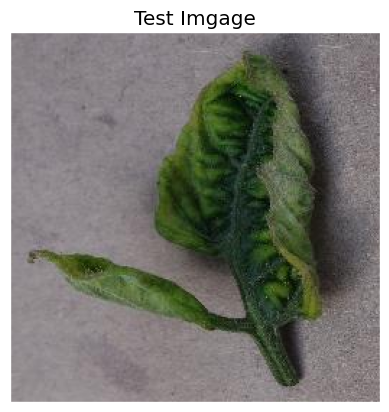

In [37]:
import cv2
image_path = '/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus3.JPG'
# Reading an image in default mode
img = cv2.imread(image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #Converting BGR to RGB
# Displaying the image 
plt.imshow(img)
plt.title("Test Imgage")
plt.xticks([])
plt.yticks([])
plt.show()

In [38]:
from tensorflow.keras.models import load_model

# Load the entire model
loaded_model = load_model('/kaggle/working/models.h5')


In [39]:
image_path = "/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus3.JPG"
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(128,128))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = loaded_model.predict(input_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [40]:
result_index = np.argmax(predictions)
print(result_index)

35


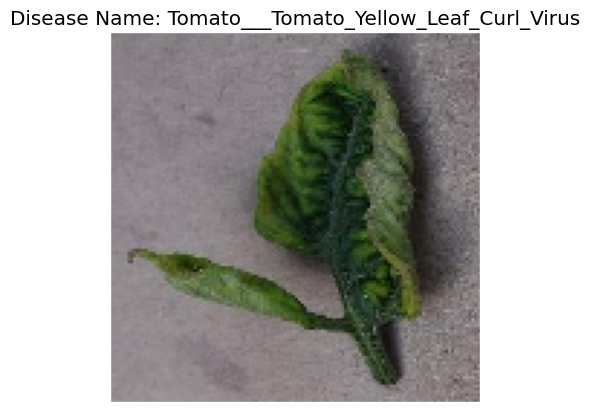

In [41]:
# Map the predicted class to label
class_names = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
                    'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 
                    'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 
                    'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 
                    'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 
                    'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot',
                    'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 
                    'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 
                    'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 
                    'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 
                    'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 
                    'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 
                    'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
# Displaying the disease prediction
model_prediction = class_names[result_index]
plt.imshow(image)
plt.title(f"Disease Name: {model_prediction}")
plt.xticks([])
plt.yticks([])
plt.show()
